In [1]:
import pandas as pd 
from utils import *
from training import *

fleet = ['VQ-BGU', 'VQ-BDU']
y_cols = ['egtm']
meta_cols = ['reportts', 'acnum', 'pos']

bgu = pd.read_csv('./takeoff-merged-VQ-BGU-30s.csv', parse_dates=['reportts']).query('egtm > 0 and oat > -100')
bdu = pd.read_csv('./takeoff-merged-VQ-BDU-30s.csv', parse_dates=['reportts']).query('egtm > 0 and oat > -100')

data = pd.concat([bgu, bdu]).sort_values('reportts').drop(columns=['file_path', 'dep', 'arr'])


### Visualize updated theta-correction procedure

In [2]:
def correct(data):
  datak = data.copy()
  alpha = 0.5
  alpha_2 = 0.84

  theta = (data['t2'] + 273.16) / (288.16)
  delta = data['p2e'] / 29.92

  datak['nfk'] = data['nf'] / (theta ** alpha)
  datak['n1ak'] = data['n1a'] / (theta ** alpha)
  datak['n1k'] = data['n1'] / (theta ** alpha)
  datak['n2ak'] = data['n2a'] / (theta ** alpha)
  datak['egtk'] = (data['egt'] + 273.16) / (theta ** alpha_2)
  datak['egtk_2'] = (data['egt'] + 273.16) / theta
  datak['ffk'] = (data['ff']) / (delta * (theta ** 0.59))

  datak['egt_peak_k'] = (data['egt_peak'] + 273.16) / (theta ** alpha_2)
  datak['n1a_peak_k'] = data['n1a_peak'] / (theta ** alpha)

  return datak

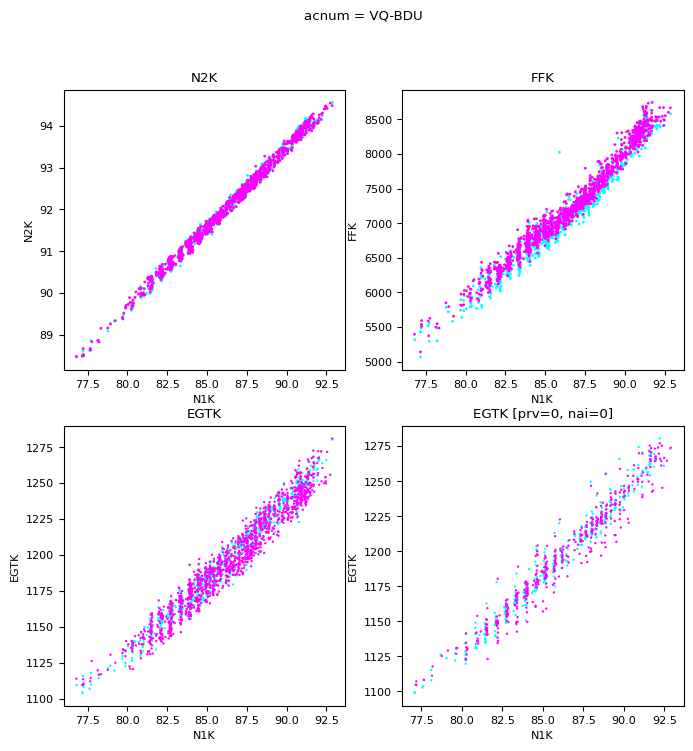

In [3]:
# features = ['egt', 'tat', 'oat', 'n1a', 'n1p', 'n1c2', 'n1ak', 'n2a', 'n2p', 'n2ak', 'nf', 'egtk', 'ff', 'ffk', 'alt', 'prv', 'nai']

data = correct(bdu)

plt.rcParams.update({'font.size': 8})
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(8, 8)
fig.suptitle('acnum = VQ-BDU')

axs[0, 0].scatter(data['n1ak'], data['n2ak'], s=1, c=data['pos'], cmap='cool')
axs[0, 0].set(xlabel='N1K', ylabel='N2K')
axs[0, 0].set_title('N2K')

axs[0, 1].scatter(data['n1ak'], data['ffk'], s=1, c=data['pos'], cmap='cool')
axs[0, 1].set(xlabel='N1K', ylabel='FFK')
axs[0, 1].set_title('FFK')

axs[1, 0].scatter(data['n1ak'], data['egtk'], s=0.5, c=data['pos'], cmap='cool')
axs[1, 0].set(xlabel='N1K', ylabel='EGTK')
axs[1, 0].set_title('EGTK')

dd = data.query('prv == 0 and nai == 0')
axs[1, 1].scatter(dd['n1c2'], dd['egtk_2'], s=0.5, c=dd['pos'], cmap='cool')
axs[1, 1].set(xlabel='N1K', ylabel='EGTK')
axs[1, 1].set_title('EGTK [prv=0, nai=0]')

plt.show()

In [4]:
# epr = data['p5'] / data['p2e']
# plt.scatter(epr, data['egtk_2'], s=0.5, c=data['pos'], cmap='cool')

Train an engine baseline:

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

model = LinearRegression()
model.fit(data[['n1ak']], data['egtk'])

pred = model.predict(data[['n1ak']])

r2 = r2_score(data['egtk'],  pred)

f"R2 = {r2}"

'R2 = 0.9534198233309993'

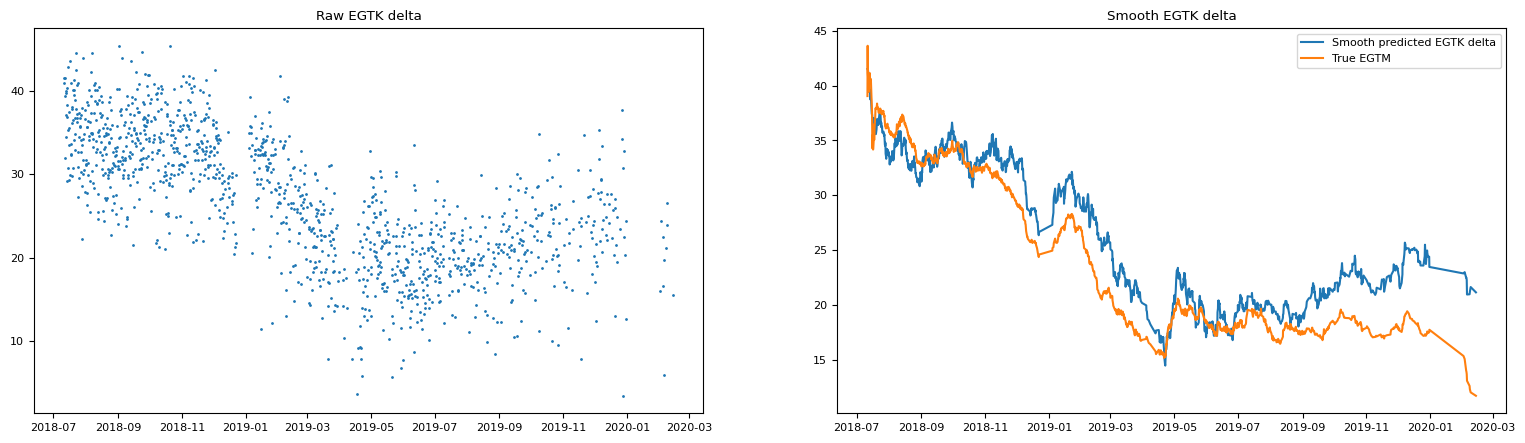

In [6]:
sub = data[data['pos'] == 2]
baseline = model.predict(sub[['n1ak']])
delta = baseline - sub['egtk'] + 26

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(19, 5)

axs[0].scatter(sub['reportts'],  delta, s=1)
axs[0].set_title('Raw EGTK delta')

axs[1].plot(sub['reportts'], smooth(delta, alpha=0.08))
axs[1].plot(sub['reportts'], sub['egtm'])
axs[1].set_title('Smooth EGTK delta')
axs[1].legend(['Smooth predicted EGTK delta', 'True EGTM'])

plt.show()

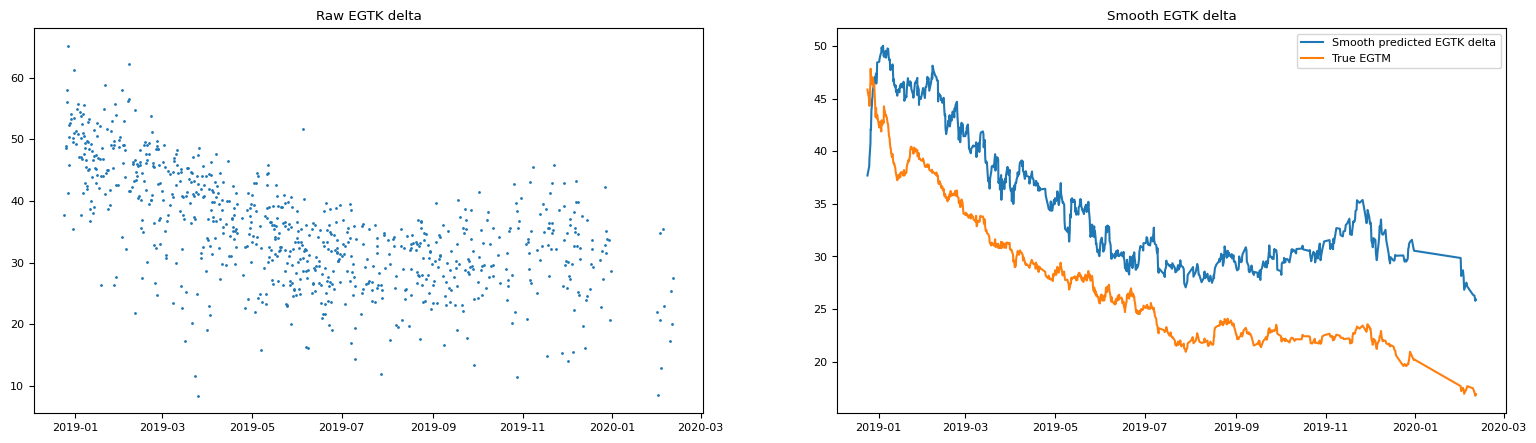

In [7]:
data_bgu = correct(bgu)
sub = data_bgu[data_bgu['pos'] == 2]
baseline = model.predict(sub[['n1ak']])
delta = baseline - sub['egtk'] + 26

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(19, 5)

axs[0].scatter(sub['reportts'],  delta, s=1)
axs[0].set_title('Raw EGTK delta')

axs[1].plot(sub['reportts'], smooth(delta, alpha=0.08))
axs[1].plot(sub['reportts'], sub['egtm'])
axs[1].set_title('Smooth EGTK delta')
axs[1].legend(['Smooth predicted EGTK delta', 'True EGTM'])

plt.show()

### Next steps:

0. Попробовать использовать EGT_peak вместо EGT

1. Вывести Delta EGTK из train выборки (75%)
2. Предсказать Delta EGTK для всего датасета и добавить как признак
3. Сравнить качество с Экспериментом 5 

4. Разделить на неск. baseline по altitude (=3000) 
5. Рекурсия 
6. Bleed учесть (bool params) 

### Try to replace EGT with EGT_peak

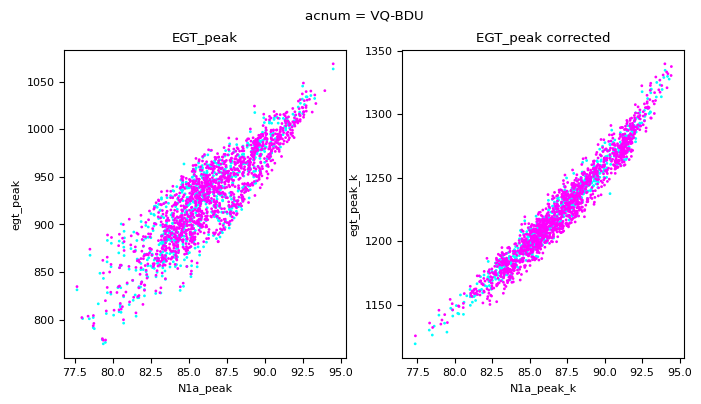

In [8]:
data = correct(bdu.query('egt_peak > 0').copy())

theta = (data['oat'] + 273.15) / 288.15
egt_peak = data['egt_peak']
egt_peak_k = (egt_peak + 273.15) / (theta ** 0.84)

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(8, 4)
fig.suptitle('acnum = VQ-BDU')

axs[0].scatter(data['n1a_peak'], egt_peak, s=1, c=data['pos'], cmap='cool')
axs[0].set(xlabel='N1a_peak', ylabel='egt_peak')
axs[0].set_title('EGT_peak')

axs[1].scatter(data['n1a_peak_k'], egt_peak_k, s=1, c=data['pos'], cmap='cool')
axs[1].set(xlabel='N1a_peak_k', ylabel='egt_peak_k')
axs[1].set_title('EGT_peak corrected')
plt.show()

### Baselines for each engine

In [9]:
def train_engine_baseline(points: pd.DataFrame, x_param='n1ak', y_param='egtk'):
  model = LinearRegression()
  model.fit(points[[x_param]], points[y_param])
  return model

def compute_egtm(points: pd.DataFrame, model: LinearRegression, x_param='n1ak'):
  offset = 30
  delta = model.predict(points[[x_param]]) - points['egtk']
  return delta + offset

def train_model(X, y):
  assert len(X) == len(y)
  train_i = int(len(X) * 50 / 100)
  X_train, y_train = X[0:train_i], y[0:train_i]
  X_test, y_test = X[train_i:], y[train_i:]

  models = {}

  predicted_test = pd.DataFrame(index=X_test.index.copy(), columns=['pred'])
  predicted_train = pd.DataFrame(index=X_train.index.copy(), columns=['pred'])
  predicted_test_smooth = pd.DataFrame(index=X_test.index.copy(), columns=['pred'])

  for acnum in fleet: 
    for pos in [1, 2]:
      train_index = (X_train['pos'] == pos) & (X_train['acnum'] == acnum)
      test_index = (X_test['pos'] == pos) & (X_test['acnum'] == acnum)

      model = train_engine_baseline(X_train[train_index])
      
      models[f'{acnum}_{pos}'] = model
      
      predicted_test.loc[test_index, 'pred'] = compute_egtm(X_test[test_index], model)
      predicted_train.loc[train_index, 'pred'] = compute_egtm(X_train[train_index], model)
      predicted_test_smooth.loc[test_index, 'pred'] = smooth(compute_egtm(X_test[test_index], model), 0.05)
  
  print("Smooth metrics: ", get_metrics(y_test, predicted_test_smooth))

  return get_metrics(y_test, predicted_test), models, predicted_train, predicted_test, train_i, y_test

In [10]:
data = pd.concat([correct(bgu), correct(bdu)]).sort_values('reportts', ignore_index=True)

X = data.drop(columns=(y_cols))
y = data['egtm']

metrics, model, predicted_train, predicted_test, train_i, y_test = train_model(X, y)

metrics

Smooth metrics:  {'rmse': 4.2768, 'mae': 3.64352, 'r2': -0.77758, 'mape': 0.16153}


{'rmse': 6.30706, 'mae': 5.04292, 'r2': -2.86586, 'mape': 0.23061}

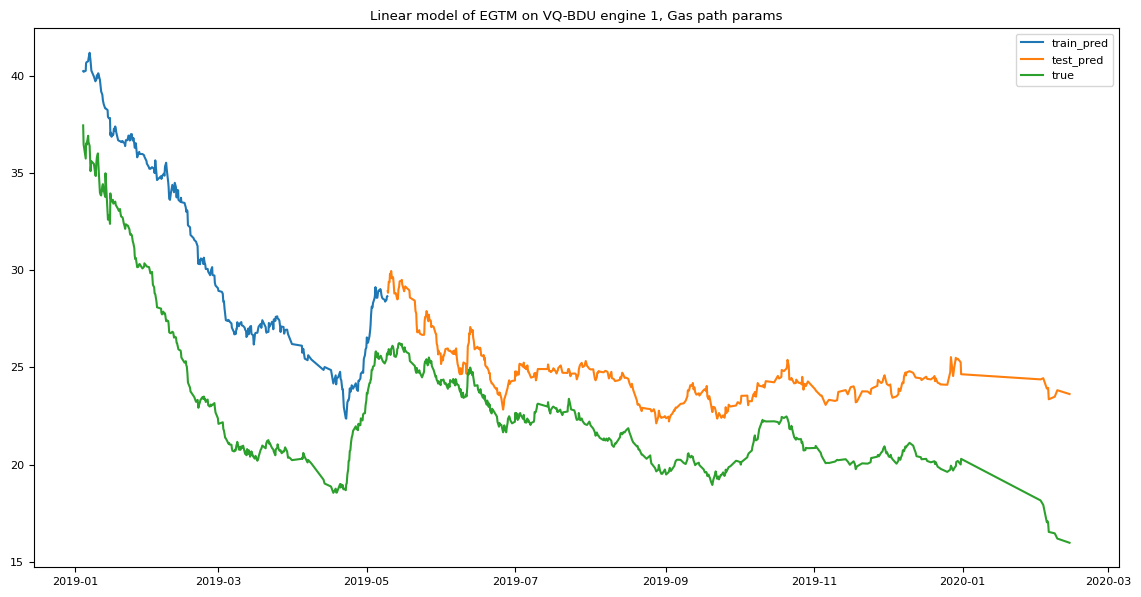

In [11]:
plot_predictions(data, 'VQ-BDU', 1, train_i, predicted_test, predicted_train, is_smooth=True, alpha=0.05)

In [12]:
bgu[['prv', 'hpv', 'wai', 'nai']].describe(percentiles=[])

,prv,hpv,wai,nai
count,1648.000000,1648.0,1648.0,1648.000000
mean,0.525485,0.0,0.0,0.098301
std,0.499502,0.0,0.0,0.297812
min,0.000000,0.0,0.0,0.000000
50%,1.000000,0.0,0.0,0.000000
max,1.000000,0.0,0.0,1.000000


Only prv and nai are present, try to filter them out and plot whats left

In [13]:
def train_model_bleed(X, y, bleed_param='prv'):
  assert len(X) == len(y)
  train_i = int(len(X) * 50 / 100)
  X_train, y_train = X[0:train_i], y[0:train_i]
  X_test, y_test = X[train_i:], y[train_i:]

  models = {}

  predicted_test = pd.DataFrame(index=X_test.index.copy(), columns=['pred'])
  predicted_train = pd.DataFrame(index=X_train.index.copy(), columns=['pred'])
  predicted_test_smooth = pd.DataFrame(index=X_test.index.copy(), columns=['pred'])

  for acnum in fleet: 
    for pos in [1, 2]:
      for bleed in [0, 1]:
        train_index = (X_train['pos'] == pos) & (X_train['acnum'] == acnum) & (X_train[bleed_param] == bleed)
        test_index = (X_test['pos'] == pos) & (X_test['acnum'] == acnum) & (X_test[bleed_param] == bleed)

        model = train_engine_baseline(X_train[train_index])
        
        models[f'{acnum}_{pos}_{bleed}'] = model
        
        predicted_test.loc[test_index, 'pred'] = compute_egtm(X_test[test_index], model)
        predicted_train.loc[train_index, 'pred'] = compute_egtm(X_train[train_index], model)

        predicted_test_smooth.loc[test_index, 'pred'] = smooth(compute_egtm(X_test[test_index], model), 0.05)

  print("Smooth metrics: ", get_metrics(y_test, predicted_test_smooth))
  
  return get_metrics(y_test, predicted_test), models, predicted_train, predicted_test, train_i, y_test

In [14]:
data = pd.concat([correct(bgu), correct(bdu)]).sort_values('reportts', ignore_index=True)

X = data.drop(columns=(y_cols))
y = data['egtm']

metrics, model, predicted_train, predicted_test, train_i, y_test = train_model_bleed(X, y)

metrics

Smooth metrics:  {'rmse': 3.82485, 'mae': 2.97605, 'r2': -0.42174, 'mape': 0.13277}


{'rmse': 6.01528, 'mae': 4.67524, 'r2': -2.51644, 'mape': 0.21365}

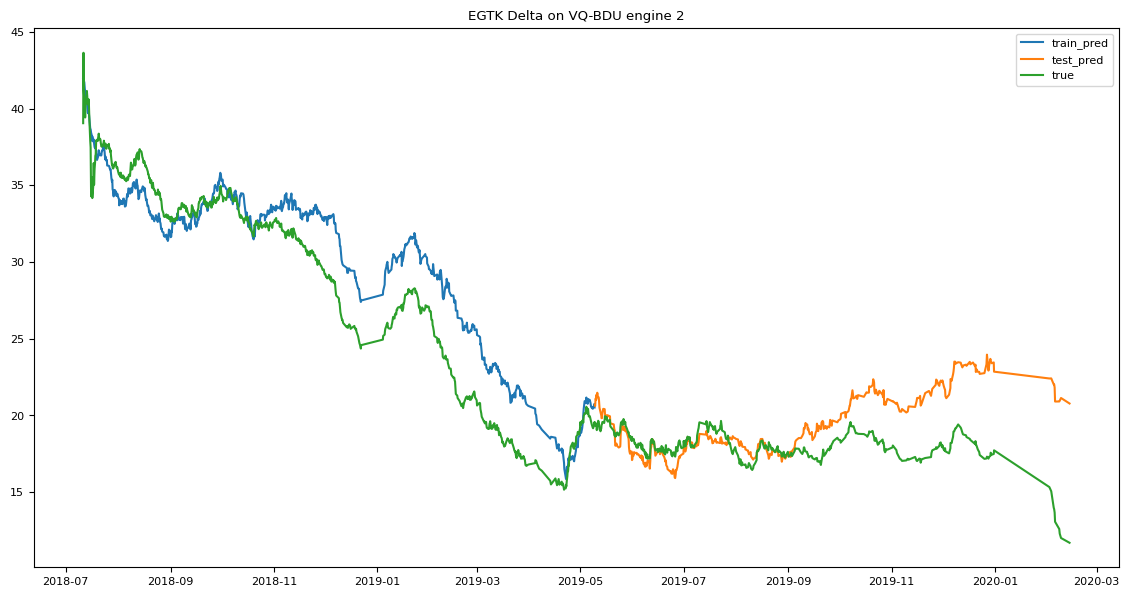

In [15]:
plot_predictions(data, 'VQ-BDU', 2, train_i, predicted_test, predicted_train, is_smooth=True, alpha=0.05, title="EGTK Delta on VQ-BDU engine 2")

In [16]:
data = pd.concat([correct(bgu), correct(bdu)]).sort_values('reportts', ignore_index=True)

X = data.drop(columns=(y_cols))
y = data['egtm']

metrics, model, predicted_train, predicted_test, train_i, y_test = train_model_bleed(X, y, bleed_param='nai')

metrics

Smooth metrics:  {'rmse': 4.2462, 'mae': 3.56932, 'r2': -0.75224, 'mape': 0.16076}


{'rmse': 6.19438, 'mae': 4.88818, 'r2': -2.72896, 'mape': 0.22498}

In [17]:
def train_model_bleed_alt(X, y, bleed_param='prv'):
  assert len(X) == len(y)
  train_i = int(len(X) * 50 / 100)
  X_train, y_train = X[0:train_i], y[0:train_i]
  X_test, y_test = X[train_i:], y[train_i:]

  models = {}

  predicted_test = pd.DataFrame(index=X_test.index.copy(), columns=['pred'])
  predicted_train = pd.DataFrame(index=X_train.index.copy(), columns=['pred'])
  predicted_test_smooth = pd.DataFrame(index=X_test.index.copy(), columns=['pred'])

  for acnum in fleet: 
    for pos in [1, 2]:
      for bleed in [0, 1]:
        for (alt_lo, alt_hi) in [[0, 3000], [3000, 10_000]]:
          train_index = (X_train['pos'] == pos) & (X_train['acnum'] == acnum) \
              & (X_train[bleed_param] == bleed) & (alt_lo <= X_train['alt']) & (X_train['alt'] < alt_hi)
          test_index = (X_test['pos'] == pos) & (X_test['acnum'] == acnum) \
              & (X_test[bleed_param] == bleed) & (alt_lo <= X_test['alt']) & (X_test['alt'] < alt_hi)

          model = train_engine_baseline(X_train[train_index])
          
          models[f'{acnum}_{pos}_{bleed}'] = model
          
          predicted_test.loc[test_index, 'pred'] = compute_egtm(X_test[test_index], model)
          predicted_train.loc[train_index, 'pred'] = compute_egtm(X_train[train_index], model)

          predicted_test_smooth.loc[test_index, 'pred'] = smooth(compute_egtm(X_test[test_index], model), 0.05)

  print("Smooth metrics: ", get_metrics(y_test, predicted_test_smooth))
  
  return get_metrics(y_test, predicted_test), models, predicted_train, predicted_test, train_i, y_test

In [18]:
data = pd.concat([correct(bgu), correct(bdu)]).sort_values('reportts', ignore_index=True)

X = data.drop(columns=(y_cols))
y = data['egtm']

metrics, model, predicted_train, predicted_test, train_i, y_test = train_model_bleed_alt(X, y, bleed_param='prv')

metrics

Smooth metrics:  {'rmse': 4.54251, 'mae': 3.37414, 'r2': -1.00532, 'mape': 0.15042}


{'rmse': 6.23128, 'mae': 4.76756, 'r2': -2.77352, 'mape': 0.2178}

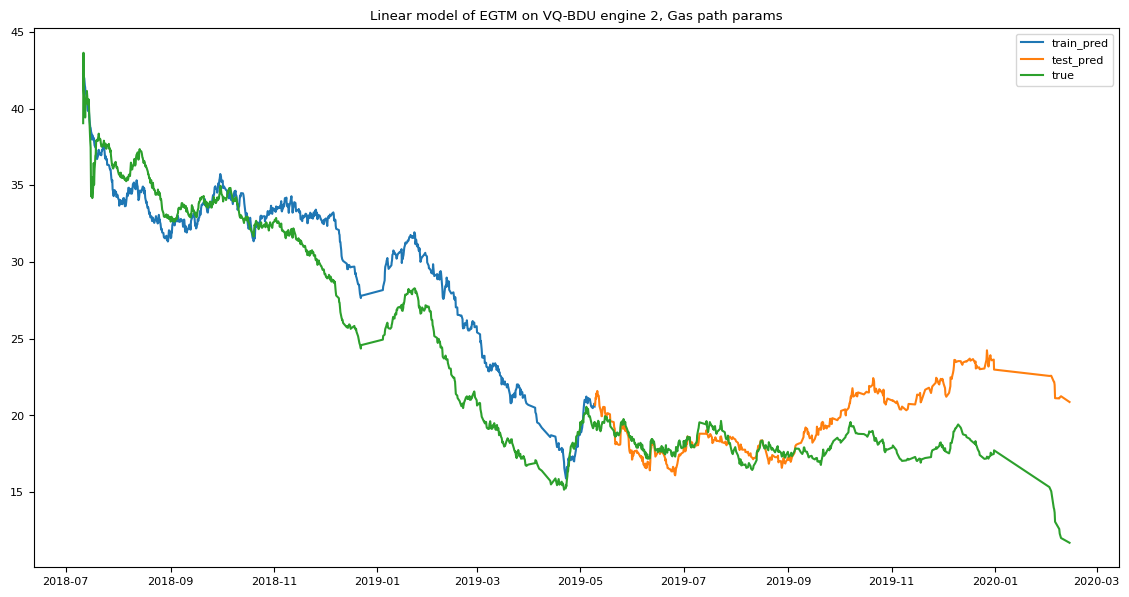

In [19]:
plot_predictions(data, 'VQ-BDU', 2, train_i, predicted_test, predicted_train, is_smooth=True, alpha=0.05)

### Add calculated EGT delta as additional property to dataset to use in recursive model later

In [20]:
def add_egt_delta_to_dataset(dataset: pd.DataFrame, bleed_param='prv', fleet=[]):
  for acnum in fleet: 
    for pos in [1, 2]:
      for bleed in [0, 1]:
        subset_index = (dataset['pos'] == pos) & (dataset['acnum'] == acnum) & (dataset[bleed_param] == bleed)
        baseline = train_engine_baseline(dataset[subset_index])
        egt_delta = compute_egtm(dataset[subset_index], baseline)
        dataset.loc[subset_index, 'egt_delta'] = egt_delta

      subset_index = (dataset['pos'] == pos) & (dataset['acnum'] == acnum) 
      egt_delta = dataset.loc[subset_index, 'egt_delta']
      egt_delta_smooth = smooth(egt_delta, 0.05)
      dataset.loc[subset_index, 'egt_delta_smooth'] = egt_delta_smooth

  return dataset

In [21]:
dataset_with_delta = add_egt_delta_to_dataset(data)

In [22]:
dataset_with_delta.to_csv("VQ-BDU_VQ-BGU_with_delta.csv", index=False)

In [23]:
dataset_with_delta.columns[dataset_with_delta.columns.str.startswith("egt")]

Index(['egtm', 'egt', 'egt_peak', 'egtb', 'egtk', 'egtk_2', 'egt_peak_k',
       'egt_delta', 'egt_delta_smooth'],
      dtype='object')

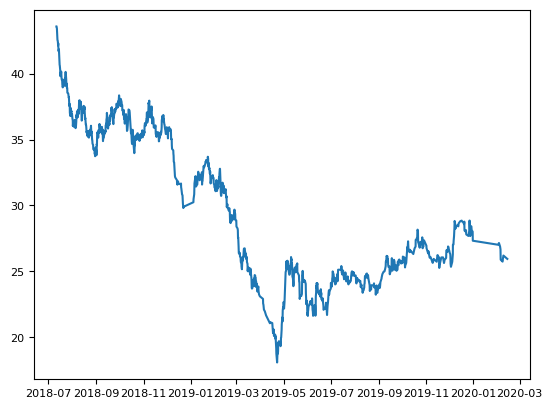

In [24]:
dd = dataset_with_delta.query('acnum=="VQ-BDU" and pos==2')
plt.plot(dd['reportts'], dd['egt_delta_smooth'])